<a href="https://colab.research.google.com/github/MarigoldJ/ygl2/blob/main/class/20210610_nlp_day2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import re, collections

# BPE 실습

## 기본 예제

* 우리들은 밥을 먹었고, 나는 공부중이다.

1. Unigram
    - 우리들은 / 밥을 / 먹었고, / 나는 / 공부중이다.
2. bigram
    - 우리들은 밥을 / 먹었고, 나는 / 공부중이다.
3. n-gram
    - (n개씩 분할)

In [ ]:
def get_stats(dictionary):
    '''
    유니 그램의 pair들의 빈도수를 카운트
    '''
    pairs = collections.defaultdict(int)
    for word, freq in dictionary.items():
        symbols = word.split()
        for i in range(len(symbols) - 1):
            pairs[symbols[i], symbols[i+1]] += freq
    
    print('현재 pair들의 빈도수 :', dict(pairs))

    return pairs


def merge_dictionary(pair, v_in):
    v_out = {}
    bigram = re.escape(' '.join(pair))
    p = re.compile(r'(?<!\S)' + bigram + r'(?!\S)')
    for word in v_in:
        w_out = p.sub(''.join(pair), word)
        v_out[w_out] = v_in[word]
    return v_out


# 아래 함수로는 왜 제대로 실행이 안될까...
def merge_dictionary_22(pair, v_in):

    v_out = {}
    bigram = re.escape(' '.join(pair))
    
    # p = re.compile(r'()?<!\S' + bigram + r'()?<!\S')
    p = re.compile(r'(?<!\S)' + bigram + r'(?<!\S)') # 여기에 <가 포함되냐 안되냐 차이인듯
    
    for word in v_in:
        w_out = p.sub(''.join(pair), word)
        v_out[w_out] = v_in[word]
    
    return v_out

In [ ]:
dictionary = {
    'l o w </w>': 5,
    'l o w e r </w>': 2,
    'n e w e s t </w>': 6,
    'w i d e s t </w>': 3,
}

bpe_codes = {}
bpe_codes_reverse = {}
num_merges = 10

for i in range(num_merges):
    print(f'>> Step {i+1}')
    pairs = get_stats(dictionary)
    best = max(pairs, key=pairs.get)
    dictionary = merge_dictionary(best, dictionary)

    bpe_codes[best] = 1
    bpe_codes_reverse[best[0] + best[1]] = best

    print(f'new merge: {best}')
    print(f'dictionary: {dictionary}')
    print()

>> Step 1
현재 pair들의 빈도수 : {('l', 'o'): 7, ('o', 'w'): 7, ('w', '</w>'): 5, ('w', 'e'): 8, ('e', 'r'): 2, ('r', '</w>'): 2, ('n', 'e'): 6, ('e', 'w'): 6, ('e', 's'): 9, ('s', 't'): 9, ('t', '</w>'): 9, ('w', 'i'): 3, ('i', 'd'): 3, ('d', 'e'): 3}
new merge: ('e', 's')
dictionary: {'l o w </w>': 5, 'l o w e r </w>': 2, 'n e w es t </w>': 6, 'w i d es t </w>': 3}

>> Step 2
현재 pair들의 빈도수 : {('l', 'o'): 7, ('o', 'w'): 7, ('w', '</w>'): 5, ('w', 'e'): 2, ('e', 'r'): 2, ('r', '</w>'): 2, ('n', 'e'): 6, ('e', 'w'): 6, ('w', 'es'): 6, ('es', 't'): 9, ('t', '</w>'): 9, ('w', 'i'): 3, ('i', 'd'): 3, ('d', 'es'): 3}
new merge: ('es', 't')
dictionary: {'l o w </w>': 5, 'l o w e r </w>': 2, 'n e w est </w>': 6, 'w i d est </w>': 3}

>> Step 3
현재 pair들의 빈도수 : {('l', 'o'): 7, ('o', 'w'): 7, ('w', '</w>'): 5, ('w', 'e'): 2, ('e', 'r'): 2, ('r', '</w>'): 2, ('n', 'e'): 6, ('e', 'w'): 6, ('w', 'est'): 6, ('est', '</w>'): 9, ('w', 'i'): 3, ('i', 'd'): 3, ('d', 'est'): 3}
new merge: ('est', '</w>')
dictio

In [ ]:
print(bpe_codes)
# bpe_code를 출력하면 merge했던 기록이 출력됨

{('e', 's'): 1, ('es', 't'): 1, ('est', '</w>'): 1, ('l', 'o'): 1, ('lo', 'w'): 1, ('n', 'e'): 1, ('ne', 'w'): 1, ('new', 'est</w>'): 1, ('low', '</w>'): 1, ('w', 'i'): 1}


## OOV에 대처하기

In [ ]:
def get_pair(word):
    pairs = set()
    prev_char = word[0]
    for char in word[1:]:
        pairs.add((prev_char, char))
        prev_char = char
    
    return pairs

def encode(orig):
    word = tuple(orig) + ('</w>',)
    print(f'__word split into character : __ <tt>{word}</tt>')

    pairs = get_pair(word)

    if not pairs:
        return orig

    iteration = 0
    while True:
        iteration += 1
        print(f'__iteration {iteration} : __')
        print(f'bigram in the word : {pairs}')

        bigram = min(pairs, key=lambda pair: bpe_codes.get(pair, float('inf')))
        print(f'candidate for merging : {bigram}')
        
        if bigram not in bpe_codes:
            print('__candidate not in BPE merges, algorithm stops.__')
            break
        
        first, second = bigram
        new_word = []
        i = 0
        while i < len(word):
            try:
                j = word.index(first, i)
                new_word.extend(word[i:j])
                i = j
            except:
                new_word.extend(word[i:])
                break
            
            if word[i] == first and i < len(word)-1 and word[i+1]==second:
                new_word.append(first+second)
                i += 2
            else:
                new_word.append(word[i])
                i += 1
        
        new_word = tuple(new_word)
        word = new_word

        print(f'word after merging: {word}')
        if len(word) == 1:
            break
        else:
            pairs = get_pair(word)
    
    # 특별 토큰 </w>는 출력하지 않는다.
    if word[-1] == '</w>':                  # </w>로 끝나는 word는
        word = word[:-1]                    # 해당 문자를 제거함
    elif word[-1].endswith('</w>'):
        word = word[:-1] + (word[-1].replace('</w>', ''),)

    return word




In [ ]:
encode('loki')

__word split into character : __ <tt>('l', 'o', 'k', 'i', '</w>')</tt>
__iteration 1 : __
bigram in the word : {('o', 'k'), ('k', 'i'), ('l', 'o'), ('i', '</w>')}
candidate for merging : ('l', 'o')
word after merging: ('lo', 'k', 'i', '</w>')
__iteration 2 : __
bigram in the word : {('k', 'i'), ('i', '</w>'), ('lo', 'k')}
candidate for merging : ('k', 'i')
__candidate not in BPE merges, algorithm stops.__


('lo', 'k', 'i')

In [ ]:
encode('lowest')

__word split into character : __ <tt>('l', 'o', 'w', 'e', 's', 't', '</w>')</tt>
__iteration 1 : __
bigram in the word : {('w', 'e'), ('l', 'o'), ('t', '</w>'), ('e', 's'), ('s', 't'), ('o', 'w')}
candidate for merging : ('l', 'o')
word after merging: ('lo', 'w', 'e', 's', 't', '</w>')
__iteration 2 : __
bigram in the word : {('w', 'e'), ('t', '</w>'), ('e', 's'), ('lo', 'w'), ('s', 't')}
candidate for merging : ('e', 's')
word after merging: ('lo', 'w', 'es', 't', '</w>')
__iteration 3 : __
bigram in the word : {('w', 'es'), ('t', '</w>'), ('lo', 'w'), ('es', 't')}
candidate for merging : ('lo', 'w')
word after merging: ('low', 'es', 't', '</w>')
__iteration 4 : __
bigram in the word : {('es', 't'), ('t', '</w>'), ('low', 'es')}
candidate for merging : ('es', 't')
word after merging: ('low', 'est', '</w>')
__iteration 5 : __
bigram in the word : {('est', '</w>'), ('low', 'est')}
candidate for merging : ('est', '</w>')
word after merging: ('low', 'est</w>')
__iteration 6 : __
bigram in

('low', 'est')

In [ ]:
encode('lowing')

__word split into character : __ <tt>('l', 'o', 'w', 'i', 'n', 'g', '</w>')</tt>
__iteration 1 : __
bigram in the word : {('l', 'o'), ('i', 'n'), ('w', 'i'), ('g', '</w>'), ('n', 'g'), ('o', 'w')}
candidate for merging : ('l', 'o')
word after merging: ('lo', 'w', 'i', 'n', 'g', '</w>')
__iteration 2 : __
bigram in the word : {('i', 'n'), ('lo', 'w'), ('w', 'i'), ('g', '</w>'), ('n', 'g')}
candidate for merging : ('lo', 'w')
word after merging: ('low', 'i', 'n', 'g', '</w>')
__iteration 3 : __
bigram in the word : {('i', 'n'), ('n', 'g'), ('low', 'i'), ('g', '</w>')}
candidate for merging : ('i', 'n')
__candidate not in BPE merges, algorithm stops.__


('low', 'i', 'n', 'g')

# IMDB 리뷰 토큰화하기

In [ ]:
import tensorflow_datasets as tfds
import urllib.request
import pandas as pd

In [ ]:
file_name = "IMDb_Reviews.csv"
urllib.request.urlretrieve("https://raw.githubusercontent.com/LawrenceDuan/IMDb-Review-Analysis/master/IMDb_Reviews.csv", filename=file_name)

('IMDb_Reviews.csv', <http.client.HTTPMessage at 0x7f969d8efe50>)

In [ ]:
train_df = pd.read_csv(file_name)
print(train_df['review'])
print('\n')
print(train_df['sentiment'])

0        My family and I normally do not watch local mo...
1        Believe it or not, this was at one time the wo...
2        After some internet surfing, I found the "Home...
3        One of the most unheralded great works of anim...
4        It was the Sixties, and anyone with long hair ...
                               ...                        
49995    the people who came up with this are SICK AND ...
49996    The script is so so laughable... this in turn,...
49997    "So there's this bride, you see, and she gets ...
49998    Your mind will not be satisfied by this nobud...
49999    The chaser's war on everything is a weekly sho...
Name: review, Length: 50000, dtype: object


0        1
1        0
2        0
3        1
4        0
        ..
49995    0
49996    0
49997    0
49998    0
49999    1
Name: sentiment, Length: 50000, dtype: int64


In [ ]:
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(train_df['review'], target_vocab_size=2**13)
# 약 5분 30초정도 소요됨.

In [ ]:
print(tokenizer.subwords[:100])
print()
print(train_df['review'][20])   # 21번째 샘플 출력
print()
print('토큰화된 샘플 질문 : {}'.format(tokenizer.encode(train_df['review'][20])))   # 21번째 샘플 출력
print()

print('단어 집합의 크기(Vocab Size) :', tokenizer.vocab_size)
print()

['the_', ', ', '. ', 'a_', 'and_', 'of_', 'to_', 's_', 'is_', 'br', 'in_', 'I_', 'that_', 'this_', 'it_', ' /><', ' />', 'was_', 'The_', 't_', 'as_', 'with_', 'for_', '.<', 'on_', 'but_', 'movie_', 'are_', ' (', 'have_', 'his_', 'film_', 'not_', 'be_', 'you_', 'ing_', ' "', 'ed_', 'it', 'd_', 'an_', 'at_', 'by_', 'he_', 'one_', 'who_', 'from_', 'y_', 'or_', 'e_', 'like_', 'all_', '" ', 'they_', 'so_', 'just_', 'has_', ') ', 'about_', 'her_', 'out_', 'This_', 'some_', 'movie', 'ly_', 'film', 'very_', 'more_', 'It_', 'what_', 'would_', 'when_', 'if_', 'good_', 'up_', 'which_', 'their_', 'only_', 'even_', 'my_', 'really_', 'had_', 'can_', 'no_', 'were_', 'see_', '? ', 'she_', 'than_', '! ', 'there_', 'been_', 'get_', 'into_', 'will_', ' - ', 'much_', 'n_', 'because_', 'ing']

Pretty bad PRC cheapie which I rarely bother to watch over again, and it's no wonder -- it's slow and creaky and dull as a butter knife. Mad doctor George Zucco is at it again, turning a dimwitted farmhand in overall

In [ ]:
print(len(tokenizer.subwords))
print(tokenizer.vocab_size)

8011
8268


In [ ]:
# 이번엔 decoding ㄱㄱ
sample_string = "It's mind-blowing to me that this film was even made."

# 인코딩해서 저장
tokenized_string = tokenizer.encode(sample_string)
print('정수 인코딩 후의 문장 : {}'.format(tokenized_string))
print()

# 이를 다시 디코딩하기
original_string = tokenizer.decode(tokenized_string)
print('기존 문장 : {}'.format(original_string))
print()

# mapping
for ts in tokenized_string:
    print(f'{ts:<5} -----> {tokenizer.decode([ts])}')

정수 인코딩 후의 문장 : [137, 8051, 8, 910, 8057, 2169, 36, 7, 103, 13, 14, 32, 18, 79, 681, 8058]

기존 문장 : It's mind-blowing to me that this film was even made.

137   -----> It
8051  -----> '
8     -----> s 
910   -----> mind
8057  -----> -
2169  -----> blow
36    -----> ing 
7     -----> to 
103   -----> me 
13    -----> that 
14    -----> this 
32    -----> film 
18    -----> was 
79    -----> even 
681   -----> made
8058  -----> .


In [ ]:
# 앞에 셀에서 조금 다르게 넣어서 ㄱㄱ
sample_string = "It's mind-blowing to me that this film was evenxyz made." # xyz가 추가됨.

# 인코딩해서 저장
tokenized_string = tokenizer.encode(sample_string)
print('정수 인코딩 후의 문장 : {}'.format(tokenized_string))
print()

# 이를 다시 디코딩하기
original_string = tokenizer.decode(tokenized_string)
print('기존 문장 : {}'.format(original_string))
print()

# mapping
for ts in tokenized_string:
    print(f'{ts:<5} -----> {tokenizer.decode([ts])}')

정수 인코딩 후의 문장 : [137, 8051, 8, 910, 8057, 2169, 36, 7, 103, 13, 14, 32, 18, 7974, 8132, 8133, 997, 681, 8058]

기존 문장 : It's mind-blowing to me that this film was evenxyz made.

137   -----> It
8051  -----> '
8     -----> s 
910   -----> mind
8057  -----> -
2169  -----> blow
36    -----> ing 
7     -----> to 
103   -----> me 
13    -----> that 
14    -----> this 
32    -----> film 
18    -----> was 
7974  -----> even
8132  -----> x
8133  -----> y
997   -----> z 
681   -----> made
8058  -----> .


# TF-IDF (Term Frequency - Inverse Document Frequency)

* 텍스트 데이터의 특징 추출

## 간단한 TF-IDF 예제 구현

In [ ]:
import pandas as pd
from math import log

In [ ]:
docs = [
    '먹고 싶은 사과',
    '먹고 싶은 바나나',
    '길고 노란 바나나 바나나',
    '저는 과일이 좋아요'
]

vocab = list(set(w for doc in docs for w in doc.split()))   # 중복 제거
vocab.sort()                                                # 정렬

print(vocab)        # 등장한 (띄어쓰기로 구분되는) 단어 종류

['과일이', '길고', '노란', '먹고', '바나나', '사과', '싶은', '저는', '좋아요']


In [ ]:
N = len(docs)       # document 총 개수 -> idf 계산시 사용
print(N)

4


In [ ]:
def tf(t, d):
    '''
    하나의 doc에서 해당 단어가 몇번 등장했는지 반환
    '''
    return d.count(t)

def idf(t):
    '''
    df = 해당 단어가 전체 doc중에서 몇 개의 doc에 등장했는지 개수를 의미
    idf = log(N / (df + 1))
    '''
    df = 0
    for doc in docs:
        df += t in doc
    
    return log(N/(df+1))

def tfidf(t, d):
    '''
    tf-idf를 계산. 식은 tf * idf로 구할 수 있음.
    '''
    return tf(t, d) * idf(t)


In [ ]:
result = []
for i in range(N):
    # i번째 doc에서 각 단어의 tfidf 계산해서 넣을 예정
    result.append([])   # i번째 doc에서 단어들의 tfidf를 저장할 list 생성
    d = docs[i]         # i번째 doc

    for j in range(len(vocab)):
        t = vocab[j]                        # 단어 지정
        result[-1].append(tfidf(t, d))      # 해당 단어가 i번째 doc에서 차지하는 중요도(tfidf) 계산

tfidf_ = pd.DataFrame(result, columns = vocab)
tfidf_

,과일이,길고,노란,먹고,바나나,사과,싶은,저는,좋아요
0,0.000000,0.000000,0.000000,0.287682,0.000000,0.693147,0.287682,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.287682,0.287682,0.000000,0.287682,0.000000,0.000000
2,0.000000,0.693147,0.693147,0.000000,0.575364,0.000000,0.000000,0.000000,0.000000
3,0.693147,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.693147,0.693147


## 사이킷런을 이용한 TF-IDF 실습

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
corpus = [
    '먹고 싶은 사과',
    '먹고 싶은 바나나',
    '길고 노란 바나나 바나나',
    '저는 과일이 좋아요'
]

In [ ]:
# 말뭉치를 Tfidf 벡터화하기
tfidfv = TfidfVectorizer().fit(corpus)

print(tfidfv.transform(corpus).toarray())
print(tfidfv.vocabulary_)

[[0.         0.         0.         0.52640543 0.         0.66767854
  0.52640543 0.         0.        ]
 [0.         0.         0.         0.57735027 0.57735027 0.
  0.57735027 0.         0.        ]
 [0.         0.47212003 0.47212003 0.         0.7444497  0.
  0.         0.         0.        ]
 [0.57735027 0.         0.         0.         0.         0.
  0.         0.57735027 0.57735027]]
{'먹고': 3, '싶은': 6, '사과': 5, '바나나': 4, '길고': 1, '노란': 2, '저는': 7, '과일이': 0, '좋아요': 8}


## 로이터 데이터로 TF-IDF 학습하기

In [ ]:
from tensorflow.keras.datasets import reuters
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [ ]:
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=10000, test_split=0.2)

2113536/2110848 [==============================] - 0s 0us/step


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/reuters.py:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/reuters.py:144: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


In [ ]:
y_train

array([ 3,  4,  3, ..., 25,  3, 25])

In [ ]:
print('훈련 샘플의 수 : {}'.format(len(x_train)))
print('테스트 샘플의 수 : {}'.format(len(x_test)))

훈련 샘플의 수 : 8982
테스트 샘플의 수 : 2246


In [ ]:
print(x_train[0])
print(x_test[0])
print(y_train[0])
print(y_test[0])

[1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]
[1, 4, 1378, 2025, 9, 697, 4622, 111, 8, 25, 109, 29, 3650, 11, 150, 244, 364, 33, 30, 30, 1398, 333, 6, 2, 159, 9, 1084, 363, 13, 2, 71, 9, 2, 71, 117, 4, 225, 78, 206, 10, 9, 1214, 8, 4, 270, 5, 2, 7, 748, 48, 9, 2, 7, 207, 1451, 966, 1864, 793, 97, 133, 336, 7, 4, 493, 98, 273, 104, 284, 25, 39, 338, 22, 905, 220, 3465, 644, 59, 20, 6, 119, 61, 11, 15, 58, 579, 26, 10, 67, 7, 4, 738, 98, 43, 88, 333, 722, 12, 20, 6, 19, 746, 35, 15, 10, 9, 1214, 855, 129, 783, 21, 4, 2280, 244, 364, 51, 16, 299, 452, 16, 515, 4, 99, 29, 5, 4, 364, 281, 48, 10, 9, 1214, 23, 644, 47, 20, 324, 27, 56, 2, 2, 5, 192, 510, 17, 12]
3
3


In [ ]:
num_classes = max(y_train) + 1
print('클래스의 수 : {}'.format(num_classes))

클래스의 수 : 46


In [ ]:
print('훈련용 뉴스의 최대 길이 : {}'.format(max(len(i) for i in x_train)))

훈련용 뉴스의 최대 길이 : 2376


In [ ]:
print('훈련용 뉴스의 평균 길이 : {}'.format(sum(len(i) for i in x_train) / len(x_train)))

훈련용 뉴스의 평균 길이 : 145.5398574927633


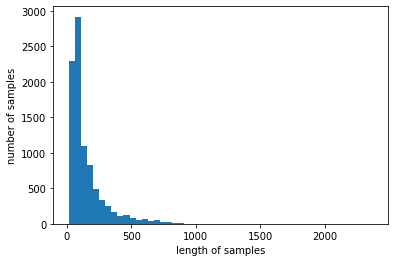

In [ ]:
plt.hist([len(s) for s in x_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


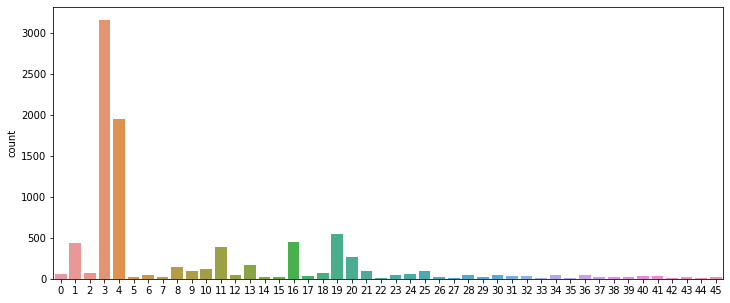

In [ ]:
fig, ax = plt.subplots(ncols=1)
fig.set_size_inches(12, 5)
sns.countplot(y_train)

In [ ]:
unique_elements, counts_elements = np.unique(y_train, return_counts=True)
print('각 클래스 빈도수 : ')
print(np.asarray((unique_elements, counts_elements)))

각 클래스 빈도수 : 
[[   0    1    2    3    4    5    6    7    8    9   10   11   12   13
    14   15   16   17   18   19   20   21   22   23   24   25   26   27
    28   29   30   31   32   33   34   35   36   37   38   39   40   41
    42   43   44   45]
 [  55  432   74 3159 1949   17   48   16  139  101  124  390   49  172
    26   20  444   39   66  549  269  100   15   41   62   92   24   15
    48   19   45   39   32   11   50   10   49   19   19   24   36   30
    13   21   12   18]]


In [ ]:
word_index = reuters.get_word_index(path='reuters_word_index.json')

557056/550378 [==============================] - 0s 0us/step


In [ ]:
print(word_index['the'])
print(word_index['it'])

1
13


In [ ]:
index_to_word = {index +3 : word for word, index in word_index.items()} # list comprehension 편안

# 왜 3을 더했는가?
# 0 - <pad>
# 1 - <sos>
# 2 - <unk>
# 위와 같이 할당하기 위해서,,

In [ ]:
print(index_to_word[1+3])
print(index_to_word[13+3])

the
it


In [ ]:
# index 0, 1, 2에 <pad>, <sos>, <unk> 할당하기
for index, token in enumerate(('<pad>', '<sos>', '<unk>')):
    index_to_word[index] = token

In [ ]:
print(' '.join([index_to_word[index] for index in x_train[0]]))

<sos> <unk> <unk> said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3


## tfidf 학습시키기

In [ ]:
# 앞에서 쓴 코드 한번 더 실행
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=10000, test_split=0.2)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/reuters.py:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/reuters.py:144: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


In [ ]:
decoded = []
for i in range(len(x_train)):
    t = ' '.join([index_to_word[index] for index in x_train[i]])
    decoded.append(t)

x_train = decoded

In [ ]:
decoded = []
for i in range(len(x_test)):
    t = ' '.join([index_to_word[index] for index in x_test[i]])
    decoded.append(t)

x_test = decoded

In [ ]:
# 잘 decoding 되었나 확인
print(x_train[:5])
print()
print(x_test[:5])

['<sos> <unk> <unk> said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3', '<sos> generale de banque sa lt <unk> br and lt heller overseas corp of chicago have each taken 50 pct stakes in <unk> company sa <unk> factors generale de banque said in a statement it gave no financial details of the transaction sa <unk> <unk> turnover in 1986 was 17 5 billion belgian francs reuter 3', '<sos> shr 3 28 dlrs vs 22 cts shr diluted 2 99 dlrs vs 22 cts net 46 0 mln vs 3 328 000 avg shrs 14 0 mln vs 15 2 mln year shr 5 41 dlrs vs 1 56 dlrs shr diluted 4 94 dlrs vs 1 50 dlrs net 78 2 mln vs 25 9 mln avg shrs 14 5 mln vs 15 1 mln note earnings per share reflect the two for one

* [위키독스 문서 참고하기](https://wikidocs.net/35342) by 강사님
* [위키독스 문서 참고하기](https://wikidocs.net/22892) <- 이건 내가 찾은 것

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB   # 다항분포 나이브 베이즈 모델
from sklearn import metrics


In [ ]:
# 단어의 수를 카운트하는 사이킷런의 카운트벡터라이저 -> 개수를 할당해줌
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(x_train)
# fit_transform : 학습할 떄와 동일한 기반 설정으로 동일하게 테스트 데이터를 변환해야 하는 것

# 카운트벡터라이저의 결과로부터 TF-IDF 결과를 얻습니다. -> TF-IDF 값을 할당해줌
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

# 나이브 베이즈 분류기를 수행합니다.
# X_trian은 TF-IDF 벡터, y_train은 레이블입니다.
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [ ]:
print(X_train_counts.shape)
print(X_train_counts)

(8982, 9670)
  (0, 111)	1
  (0, 135)	1
  (0, 172)	1
  (0, 218)	1
  (0, 248)	2
  (0, 249)	1
  (0, 291)	1
  (0, 383)	1
  (0, 607)	1
  (0, 828)	1
  (0, 1233)	1
  (0, 1508)	1
  (0, 1677)	1
  (0, 1919)	1
  (0, 2334)	1
  (0, 2565)	1
  (0, 2655)	1
  (0, 3036)	1
  (0, 3143)	1
  (0, 3475)	6
  (0, 3608)	1
  (0, 3945)	1
  (0, 4211)	1
  (0, 4325)	3
  (0, 4945)	3
  :	:
  (8981, 6257)	1
  (8981, 6389)	1
  (8981, 6407)	3
  (8981, 6419)	1
  (8981, 6985)	1
  (8981, 7294)	1
  (8981, 7335)	1
  (8981, 7489)	1
  (8981, 7537)	1
  (8981, 7666)	1
  (8981, 7834)	4
  (8981, 7852)	1
  (8981, 8106)	1
  (8981, 8112)	1
  (8981, 8153)	1
  (8981, 8272)	1
  (8981, 8817)	1
  (8981, 8848)	2
  (8981, 8850)	9
  (8981, 8852)	1
  (8981, 8932)	2
  (8981, 9133)	1
  (8981, 9181)	2
  (8981, 9246)	1
  (8981, 9594)	1


In [ ]:
print(X_train_tfidf.shape)
print(X_train_tfidf)

(8982, 9670)
  (0, 9628)	0.06356670958147888
  (0, 9218)	0.08780620595054514
  (0, 9181)	0.08604864459739914
  (0, 8932)	0.25028101697583904
  (0, 8890)	0.0930998381922142
  (0, 8875)	0.07672366483129915
  (0, 8850)	0.03988247757031195
  (0, 8303)	0.203150231713389
  (0, 8272)	0.030312371161604353
  (0, 8175)	0.1025062385626965
  (0, 8106)	0.22747636818044054
  (0, 8055)	0.25190182137461803
  (0, 7834)	0.1219387278172762
  (0, 7727)	0.1102444102744686
  (0, 7675)	0.13792521715667663
  (0, 7666)	0.030539304325861907
  (0, 7633)	0.1272430689584012
  (0, 7508)	0.21863456761984176
  (0, 6972)	0.1539628581207626
  (0, 6682)	0.27676451799730706
  (0, 6429)	0.15755807940652689
  (0, 6365)	0.11453293816669016
  (0, 6253)	0.10419591024092598
  (0, 6218)	0.07042182393755048
  (0, 6042)	0.21345820216754235
  :	:
  (8981, 3632)	0.08621812797387604
  (8981, 3491)	0.07481068075649426
  (8981, 3155)	0.08709921432098085
  (8981, 3136)	0.08181638104840938
  (8981, 3046)	0.08006841942701773
  (8981, 293

In [ ]:
def tfidf_vectorizer(data):
    data_counts = count_vect.transform(data)
    data_tfidf = tfidf_transformer.transform(data_counts)
    return data_tfidf

In [ ]:
y_pred = clf.predict(tfidf_vectorizer(x_test))
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.62      0.69      0.65       105
           2       0.00      0.00      0.00        20
           3       0.81      0.90      0.85       813
           4       0.51      0.96      0.67       474
           5       0.00      0.00      0.00         5
           6       0.00      0.00      0.00        14
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00        38
           9       1.00      0.08      0.15        25
          10       0.00      0.00      0.00        30
          11       0.66      0.63      0.64        83
          12       0.00      0.00      0.00        13
          13       1.00      0.03      0.05        37
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         9
          16       0.69      0.56      0.61        99
          17       0.00    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print('정확도 :', metrics.accuracy_score(y_test, y_pred))

정확도 : 0.6567230632235085
